# Exploring the feature space of human knowledge about common objects

## Introduction


Human mind is able to process things and moments vividly perceived in daily life into abstract concepts and semantic knowledge. Understanding the nature of human knowledge has been a central question in psychology, and it may also have theoretical and practical implications for the field of artificial intelligence. One key characteristic of human knowledge is its structured nature, which allows new pieces of information (e.g., a plant that a person sees for the first time) to be learned efficiently by integrating it *into* existing categories (Orchidaceae -> Phragmipedium). Meanwhile, those categories are built upon concrete information that has been experienced by the person over time (e.g., different orchid species).
<div>
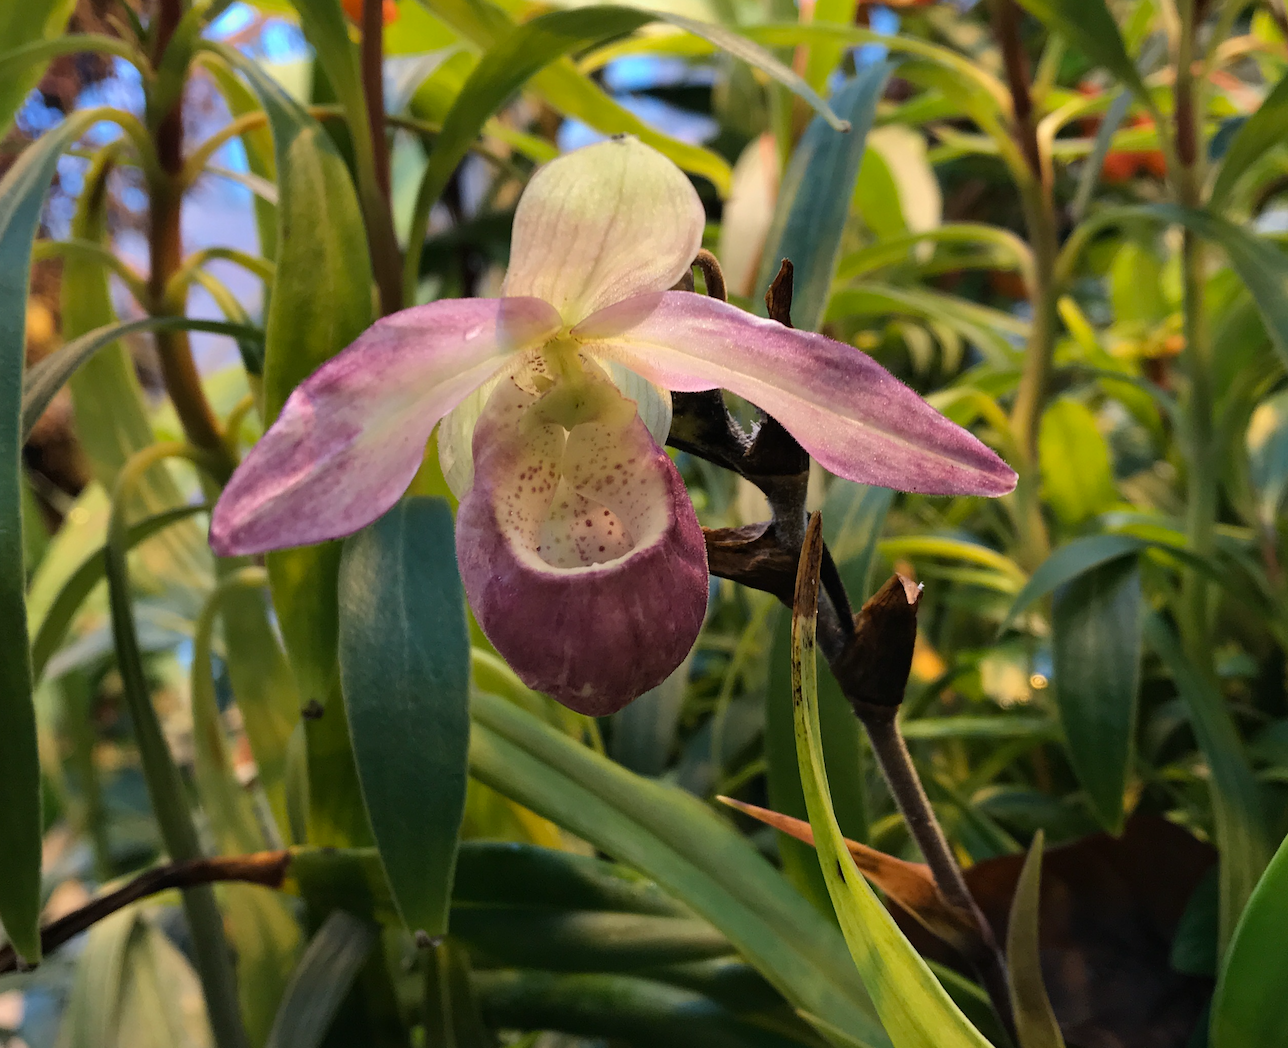
</div>


Semantic knowledge can be conveniently extracted from large corpus of texts and subsequently used for trainning word embeddings in an unsupervised manner, but it remains a challenge to fully understand the meaning of the embedding space. Another approach, which is more labor-intensive but has better explainability, is to obtain collective descriptions of concepts from human participants. This paradigm is able to curate structured dataset of concepts with a list of explainable semantic attributes that belongs to each individual concept. Efforts in this area include the works from the McRae Group (https://sites.google.com/site/kenmcraelab/contact) and, more recently, the works from the research group that I'm currently working in (see: https://link.springer.com/article/10.3758/s13421-020-01130-5). 


Specifically, in the study from our group, 566 participants were recruited on the Amazon Mechanical Turk platform to perform a description task on 995 concepts of objects. For each object, participants were shown an exemplar image of the object and prompted to describe 5 unique features using drop-down menus and text boxes. The responses from all participants were then aggregated by objects, and this lead to **5559 unique descriptions** of the features across all objects. **In other words, each object can be viewed as located somewhere in a 5559-dimension semantic feature space.** However, since each object has relatively limited number of features, the feature space is inevitably very sparse, meaning that the elements in an object's feature vector would be mostly zero. Therefore, it would be interesting to ask 1) whether these objects can be represented in a more **compact**, low-dimension space, 2) how to find such low-dimension space, and 3) whether some information in the original high-dimension space can be preserved (or even strengthened) in the low-dimension space.
<div>
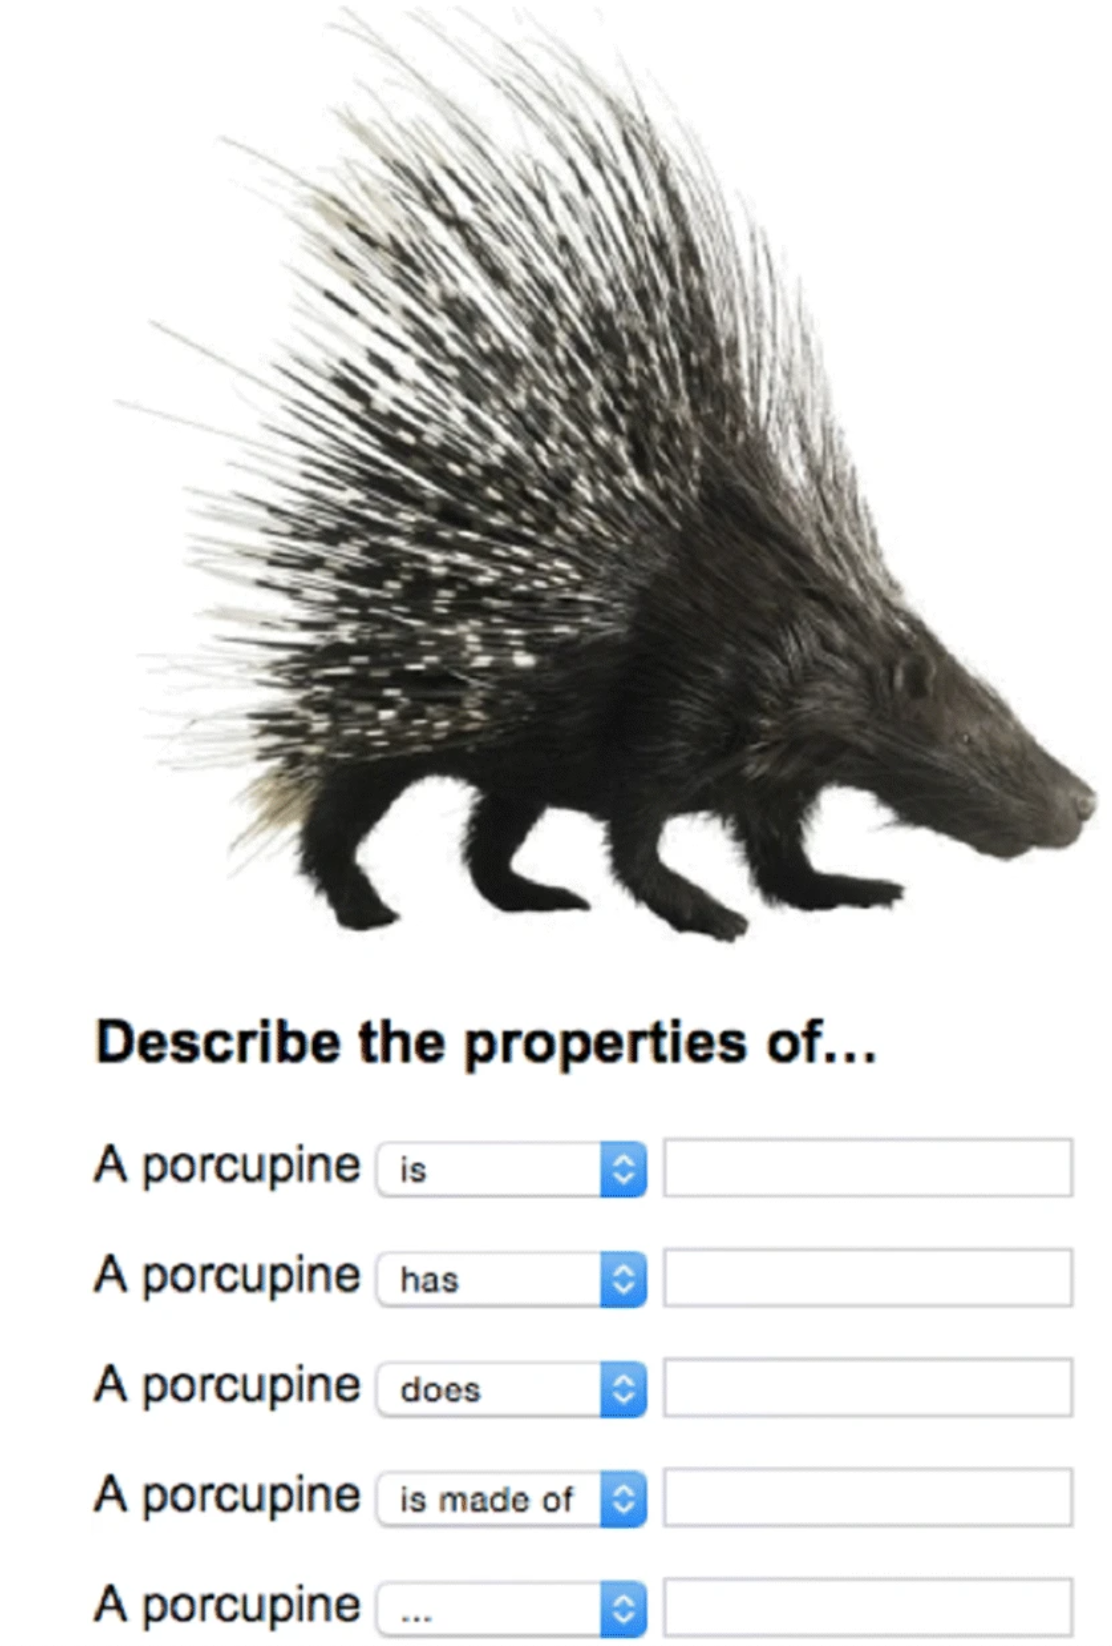
</div>


The dataset is publicly available on Open Science Foundation website (https://osf.io/49zej/). Note that the dataset also includes object images, which may be of interest to some of the readers whose expertise involve human/computer vision. For the current analysis, we will be looking only at the semantic features.





.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.manifold import TSNE
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [41]:
df_all=pd.read_csv('conceptFreqMatrix.csv')
df_all.head(5)

ID          concept             category     domain  is_made_of_metal  \
0   1      accent lamp            furniture  nonliving                 0   
1   2        accordion  musical instruments  nonliving                 4   
2   3  acoustic guitar  musical instruments  nonliving                 3   
3   4      agave plant                plant     living                 0   
4   5  air conditioner         street items  nonliving                18   

   is_made_of_wood  is_made_of_plastic  is_useful  has_a_handle  is_small  \
0                0                   1          3             0         5   
1                2                   2          0             0         0   
2               28                   1          0             2         0   
3                0                   0          2             0         0   
4                0                   3          5             0         1   

   ...  does_get_messy  does_film  does_cool_a_person  allows_for_hiding  \
0  ...               0          0                   0                  0   
1  ...               0          0                   0                  0   
2  ...               0          0                   0                  0   
3  ...               0          0                   0                  0   
4  ...               0          0                   0                  0   

   does_cool_a_room  does_keep_hands_clean  does_hold_chess_pieces  \
0                 0                      0                       0   
1                 0                      0                       0   
2                 0                      0                       0   
3                 0                      0                       0   
4                 0                      0                       0   

   does_come_from_birds  does_cause_allergies  does_keep_order  
0                     0                     0                0  
1                     0                     0                0  
2                     0                     0                0  
3                     0                     0                0  
4                     0                     0                0  

[5 rows x 5563 columns]

-----------------

get all feature names

In [14]:
featnames=df_all.columns.to_list()
featnames=featnames[4:]
print('number of rows: {}'.format( df_all.shape[0] ))
print('number of object concepts: {}'.
      format( len( df_all['concept'].unique() ) ))
print('number of categories: {}'.
      format( len(df_all['category'].unique()) ))
print('number of domains: {}'.
      format( len(df_all['domain'].unique()) ))

number of rows: 994
number of object concepts: 994
number of categories: 29
number of domains: 2


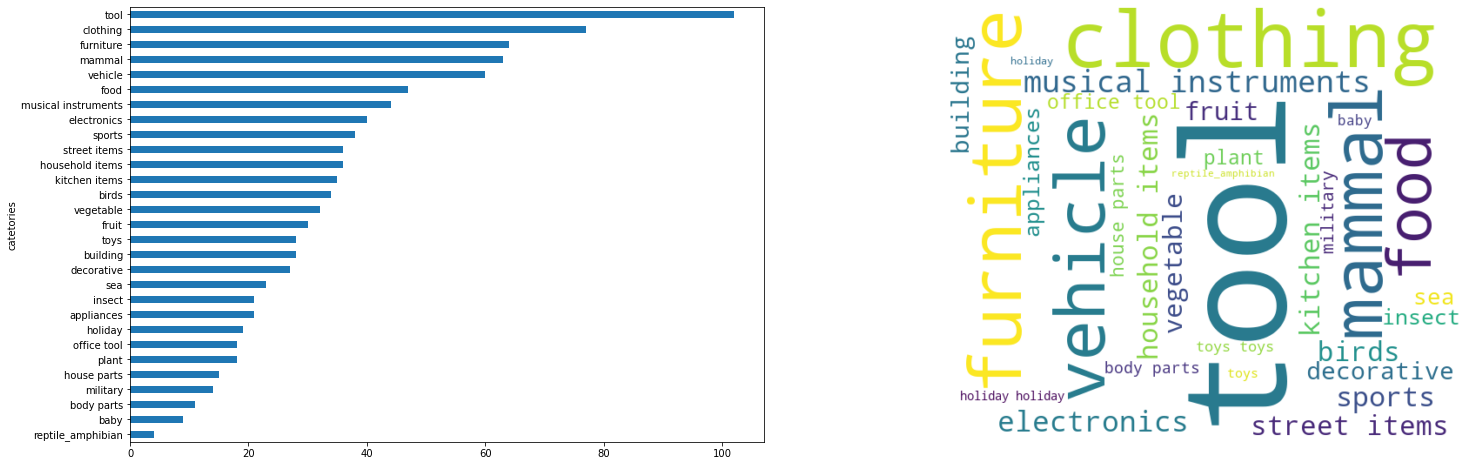

In [43]:
category_count=df_all.groupby('category')['category'].count()

fig,Ax = plt.subplots(1,2)

tmp=category_count.sort_values(ascending=True)
tmp.plot.barh(ax=Ax[0])
plt.setp(Ax[0],ylabel='catetories')

tmpstr=''
for i in df_all['category']:
    tmpstr=tmpstr + ' ' + i.replace(' ', '-')
wcloud=WordCloud(background_color='white',width=600,height=500)
wcloud.generate(tmpstr)
Ax[1].imshow(wcloud, interpolation='bilinear')
Ax[1].axis('off')

fig.set_figwidth(25) # set width
fig.set_figheight(8) # set height

Let's take a look at some example features. Here are a few features that are either very common, relatively common, or very rare

In [39]:
tmp=df_all.iloc[:,4:].sum(axis=0)
tmp[[2,4,5,180,200,300,2500,3500,4500]]

is_made_of_plastic    2955
has_a_handle          1741
is_small              1314
is_rectangular          91
has_fins                85
has_glass               57
is_low_calorie           6
is_for_birthdays         4
is_for_stabbing          3
dtype: int64

### Let's take a look at the distribution of features across objects

[Text(0.5, 0, 'number of features an object has'), Text(0, 0.5, 'frequency')]

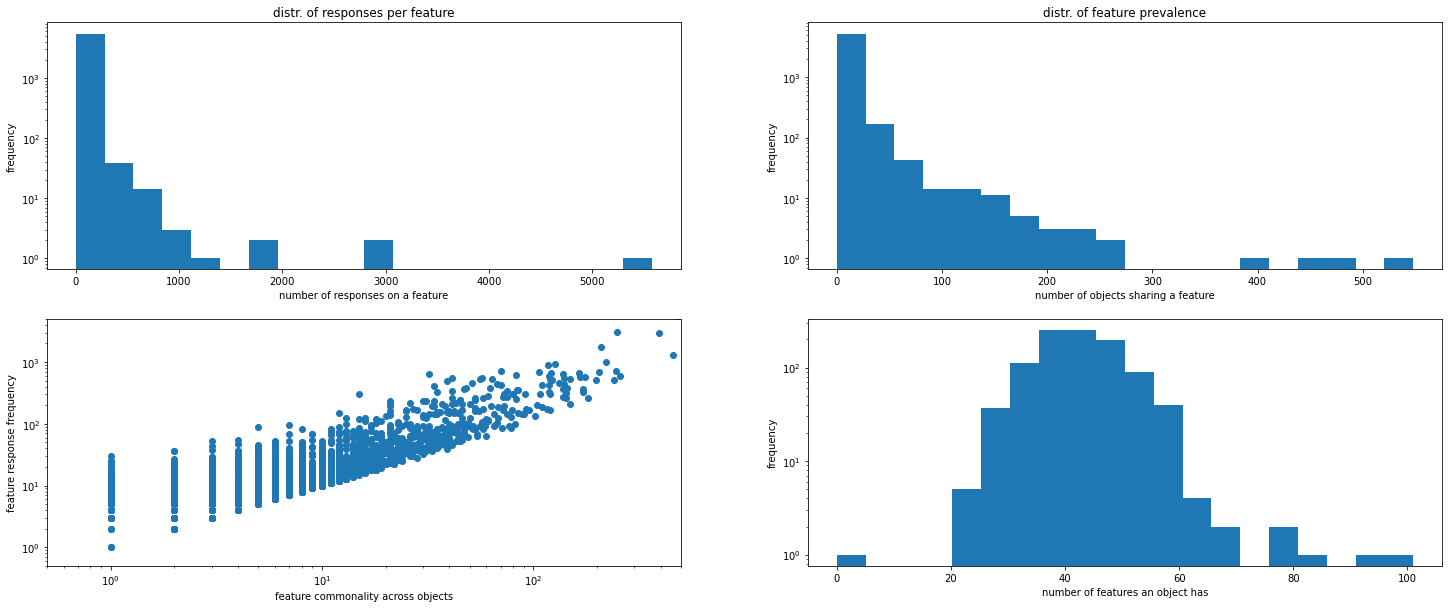

In [45]:
g,Ax=plt.subplots(2,2)
g.set_size_inches(25,10)

tmp=df_all.iloc[:,4:].sum(axis=0)
Ax[0,0].hist(tmp,log=True,bins=20)
Ax[0,0].set_title('distr. of responses per feature')
plt.setp(Ax[0,0],xlabel='number of responses on a feature',
         ylabel='frequency')

tmp=(df_all.iloc[:,4:]!=0).sum(axis=0)
Ax[0,1].hist(tmp,log=True,bins=20)
Ax[0,1].set_title('distr. of feature prevalence')
plt.setp(Ax[0,1],xlabel='number of objects sharing a feature',
         ylabel='frequency')

Ax[1,0].scatter(x=(df_all.iloc[:,4:]!=0).sum(axis=0),y=df_all.iloc[:,4:].sum(axis=0))
Ax[1,0].set_xscale('log'),Ax[1,0].set_yscale('log')
plt.setp(Ax[1,0],xlabel='feature commonality across objects',
         ylabel='feature response frequency')
Ax[1,0].set_xlim([.5,500]),Ax[1,0].set_ylim([.5,5000])

tmp=(df_all.iloc[:,4:]!=0).sum(axis=1)
Ax[1,1].hist(tmp,log=True,bins=20)
plt.setp(Ax[1,1],xlabel='number of features an object has',
         ylabel='frequency')


#### Some conclusions from the above figures:
1) For one given feature, it is most likely described for less than 1000 times across all participants and all objects
2) For one given feature, it is unlikely that this feature can be found in over 200 different objects
3) The more frequently a feature is described by participants, the prevalent it exists in multiple objects
4) Most objects have around 20~60 unique features


-----------------

### Now, we explore if objects belonging to the same category will be more similar in the feature space

First, we define similarity between two **objects** using the cosine distance. For two objects with feature vectors $X$ and $Y$ , respectively, the distance between them would be:

$Dist(X,Y) = 1 - X \cdot Y / (|X|*|Y|)$

Note that broadcasting and matrix operation is used to accelerate computation.


Then, we can define the distances between two **categories** $A$ and $B$ as the average distances between objects in the given two categories.

$Dist(A,B) = mean( Dist(X,Y) )$, for all  $X \in A$  and  $Y \in B$


In [40]:
from util_func import cos_dist, categorical_dist
# -- below are the definitions of the same two functions 

def cos_dist(x, y):
    norm_x = x / (np.linalg.norm(x, axis=1, keepdims=True)+0.000001) # add a small value to the denominator to avoid division by 0
    norm_y = y / (np.linalg.norm(y, axis=1, keepdims=True)+0.000001)
    return 1 - np.matmul(norm_x, norm_y.T)

def categorical_dist(featmtx,categorylabels,categorynames):
    objdistmtx=cos_dist(featmtx,featmtx)#distance_matrix(featmtx,featmtx)
    catdistmtx=np.zeros((len(categorynames),len(categorynames)))
    for i in range(len(categorynames)):
        tmpind_i=(categorylabels== #['category']
                  categorynames[i]).to_numpy()
        for j in range(len(categorynames)):
            tmpind_j=(categorylabels== #['category']
                      categorynames[j]).to_numpy()
            catdistmtx[i,j]=np.mean(objdistmtx[tmpind_i,:][:,tmpind_j])
    return catdistmtx

Let's take a look at the category-level distance matrix. Specifically, we arrange the categories by their living-ness. Non-living categories precede living categories.

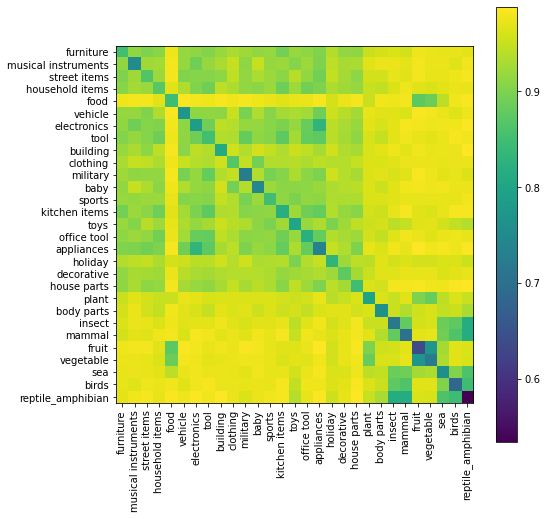

In [19]:
categoryNames=df_all[df_all['domain']=='nonliving']['category'].unique().tolist()
categoryNames.extend(
    df_all[df_all['domain']=='living']['category'].unique().tolist())

FeatMtx=(df_all.iloc[:,4:]!=0).to_numpy()

CatDistMtx=categorical_dist(FeatMtx,
                            categorylabels=df_all['category'],
                            categorynames=categoryNames)
plt.figure(figsize=(8,8))
plt.imshow(CatDistMtx)
locs,labels=plt.yticks(list(range(0,len(categoryNames))),
                       labels=categoryNames)
locs,labels=plt.xticks(list(range(0,len(categoryNames))),
                       labels=categoryNames,rotation=90)
_ = plt.colorbar()

#### Two observations can be drawn from the category-level similarity matrix:
1) Within-category distance (average distance among objects within the same category, shown as the diagonal entries in the matrix) are smaller than between-category distance, meaning that objects in the same category are more similar in their semantic features
2) It is visually obvious that living categories are more similar to other living categories, while non-living categories are more similar to other non-living ones.


 ------------------


Now, let's define categorical distinctiveness as the average cosine distances between categories over the average distances within each categories.

$Distinctiveness = \frac{mean( Dist(A,B) )}{ mean( Dist(A,A) )}$, for all categories $A$ and $B$ , with constraint:  $A \neq B$

This distinctiveness measure will indicate **the extend to which the semantic feature space contains categorical information**. In other words, the greater it is than 1, the more the feature space is able to distinguish between different categories.

In [20]:
def category_distinctiveness(Mtx):
    n=Mtx.shape
    msk=np.eye(n[0])
    Dg=np.mean(Mtx.flatten()[msk.flatten()==1])
    nonDg=np.mean(Mtx.flatten()[msk.flatten()==0])
    return nonDg/Dg

print('category distinctiveness = {}'.format(category_distinctiveness(CatDistMtx)))

CatDistMtx=categorical_dist(FeatMtx,
                            categorylabels=df_all['domain'],
                            categorynames=['living','nonliving'])
print('domain distinctiveness = {}'.format(category_distinctiveness(CatDistMtx)))


category distinctiveness = 1.2081808071910705
domain distinctiveness = 1.0719800267673578


Indeed, both category and domain show distinctiveness above 1

--------------

### Data cleaning -- excluding uncommon features

The dimension of the feature space is way too high (>5500)! Most of the features are rarely described by more than a handful participants and rarely shared across objects, which means they are mostly unused. Dropping these features can make computation much simpler, but dropping too much features may lead to insufficient description. We need to understand whether dropping features will lead to a loss of information. Here we will see how the categorical information in the dataset changes as the number of features reduces

Two criteria are used to eliminate uncommon features:
1) the number of categories a feature describes
2) the number of times a feature has been described by the participants

In [47]:
FeatMtx_raw=(df_all.iloc[:,4:]).to_numpy()

exclude_thr1=[0,5,10,15,20] #shared categories
exclude_thr2=[0,5,10,15,20,25,30,35,40,45,50] #number of responses

optMtx=np.zeros((len(exclude_thr1),len(exclude_thr2)))
featnumberMtx=np.zeros((len(exclude_thr1),len(exclude_thr2)))

for i in range(len(exclude_thr1)):
    for j in range(len(exclude_thr2)):
        tmp1=(FeatMtx_raw!=0).sum(axis=0)>=exclude_thr1[i]
        tmp2=FeatMtx_raw.sum(axis=0)>=exclude_thr2[j]
        tmpind = tmp1&tmp2
        FeatMtx = FeatMtx_raw[:,tmpind]!=0
        CatFeatDistMtx=categorical_dist(FeatMtx,
                                        categorylabels=df_all['category'],
                                        categorynames=categoryNames)
        optMtx[i,j]=category_distinctiveness(CatFeatDistMtx)
        featnumberMtx[i,j]=FeatMtx.shape[1]

minimum distinctiveness 1.20818080719107
maximum distinctiveness 1.3757909555475245


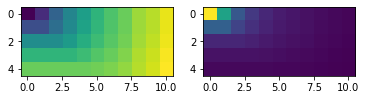

In [48]:
g,Ax=plt.subplots(1,2)
Ax[0].imshow(optMtx)
Ax[1].imshow(featnumberMtx)

print('minimum distinctiveness {}'.format(np.min(optMtx)) )
print('maximum distinctiveness {}'.format(np.max(optMtx)) )

As you can see, dropping uncommon features actually helps increase the categorical distinctiveness of the dataset. This is probably because when ignoring those uncommon and unique features, objects within the same category will share more commonalities.

-------------

For simplicity, we will exclude features that are extremely uncommon, e.g., those with less than 25 responses or shared by less than 5 different objects. To further simplify, we exclude two categories ('reptile_amphibian','baby') whose sizes are less than 10% the size of the largest category ('tool'). We also exclude objects that have less than 5 features ('nose', 'poison'). All these decisions are more or less arbitrary, but they nevertheless give a 'cleaner' dataset, which all the following analyses will be based upon.

(981, 655)
979
['nose', 'poison']
(979, 655)
category distinctiveness after dropping features 1.3052576841832146
domain distinctiveness after dropping features 1.1188959131100995


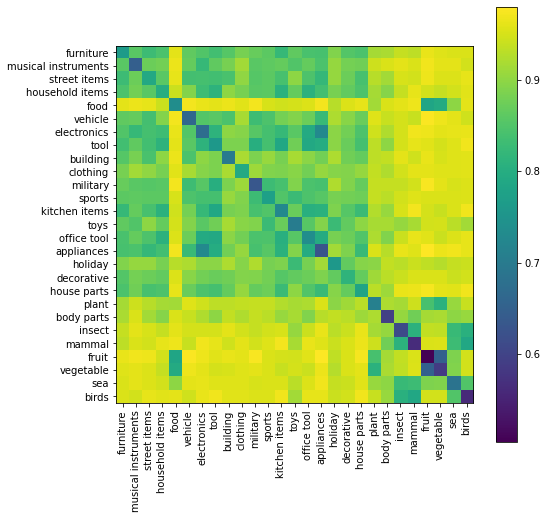

In [54]:
#exclude categories ('reptile_amphibian','baby') whose sizes are less than 10% the size of the largest category ('tool')
df_all2=df_all[ ~df_all['category'].isin(['reptile_amphibian','baby']) ]

tmp1=(df_all2.iloc[:,4:]!=0).sum(axis=0)>=5
tmp2=df_all2.iloc[:,4:].sum(axis=0)>=25
tmpind=(tmp1&tmp2).to_numpy()
tmpind=np.concatenate(([1,1,1,1],tmpind*1))

df_hifreq=pd.DataFrame.copy(df_all2)
df_hifreq=df_hifreq.iloc[:,tmpind!=0]
print(df_hifreq.shape)

#exclude objects that have very few features
tmp1=(df_hifreq.iloc[:,4:]!=0).sum(axis=1)>5 
print(sum(tmp1))
print(df_hifreq['concept'][tmp1==0].to_list())

df_hifreq=df_hifreq[tmp1]
print(df_hifreq.shape)


categoryNames=df_hifreq[df_hifreq['domain']=='nonliving']['category'].unique().tolist()
categoryNames.extend(
    df_hifreq[df_hifreq['domain']=='living']['category'].unique().tolist())

domainNames=['living','nonliving']
CatDistMtx=categorical_dist((df_hifreq.iloc[:,4:]>0).to_numpy(),
                          categorylabels=df_hifreq['category'],
                          categorynames=categoryNames)
print('category distinctiveness after dropping features {}'.format(
    category_distinctiveness(CatDistMtx) ) )

plt.figure(figsize=(8,8))
plt.imshow(CatDistMtx)
locs,labels=plt.yticks(list(range(0,len(categoryNames))),
                       labels=categoryNames)
locs,labels=plt.xticks(list(range(0,len(categoryNames))),
                       labels=categoryNames,rotation=90)
_ = plt.colorbar()

CatDistMtx=categorical_dist((df_hifreq.iloc[:,4:]!=0).to_numpy(),
                          categorylabels=df_hifreq['domain'],
                          categorynames=domainNames)
print('domain distinctiveness after dropping features {}'.format(
    category_distinctiveness(CatDistMtx) ) )



We can see that the 'cleaned' feature space has higher categorical and domain distinctiveness.

---------------

## Visualizing the similarity between objects and categories using dimension reduction

High-dimensional data can not be directly visualized unless it's been transformed into a lower-dimensional space, where the number of dimensions is usually 2 or 3. There are many different algorithms for dimensional reduction, while the most well-known one is probably principal component analysis (PCA). However, PCA is based on the covariance method and works best for continuous and normal-distributed data. Since the feature vector of an object is binary (the object will either have or not have a certain feature), PCA may not be the ideal method to use.

**Instead, we used t-SNE to reduce the dimension of the dataset**

The following text from Wikipedia explains how t-SNE works:

'**t-distributed stochastic neighbor embedding (t-SNE)** is a statistical method for visualizing high-dimensional data by giving each datapoint a location in a two or three-dimensional map.' ... 'It is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. **Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability.** The t-SNE algorithm comprises two main stages. First, t-SNE constructs a probability distribution over pairs of high-dimensional objects in such a way that similar objects are assigned a higher probability while dissimilar points are assigned a lower probability. Second, t-SNE defines a similar probability distribution over the points in the low-dimensional map, and it minimizes the Kullback–Leibler divergence (KL divergence) between the two distributions with respect to the locations of the points in the map. While the original algorithm uses the Euclidean distance between objects as the base of its similarity metric, this can be changed as appropriate.'

We now feed the feature vectors of all objects (or feature matrix   $X$   ) into t-SNE and obtain the low-dimensional embedding (  $X \_ embedded$   ) of the feature space: 

In [22]:
X=df_hifreq.iloc[:,4:].to_numpy() #this is the feature matrix (object x features)

X_embedded = TSNE(n_components=2).fit_transform(X!=0)
df_tsnevis=pd.DataFrame()
df_tsnevis['category']=df_hifreq['category']
df_tsnevis['domain']=df_hifreq['domain']
df_tsnevis['dim1']=X_embedded[:,0]
df_tsnevis['dim2']=X_embedded[:,1]

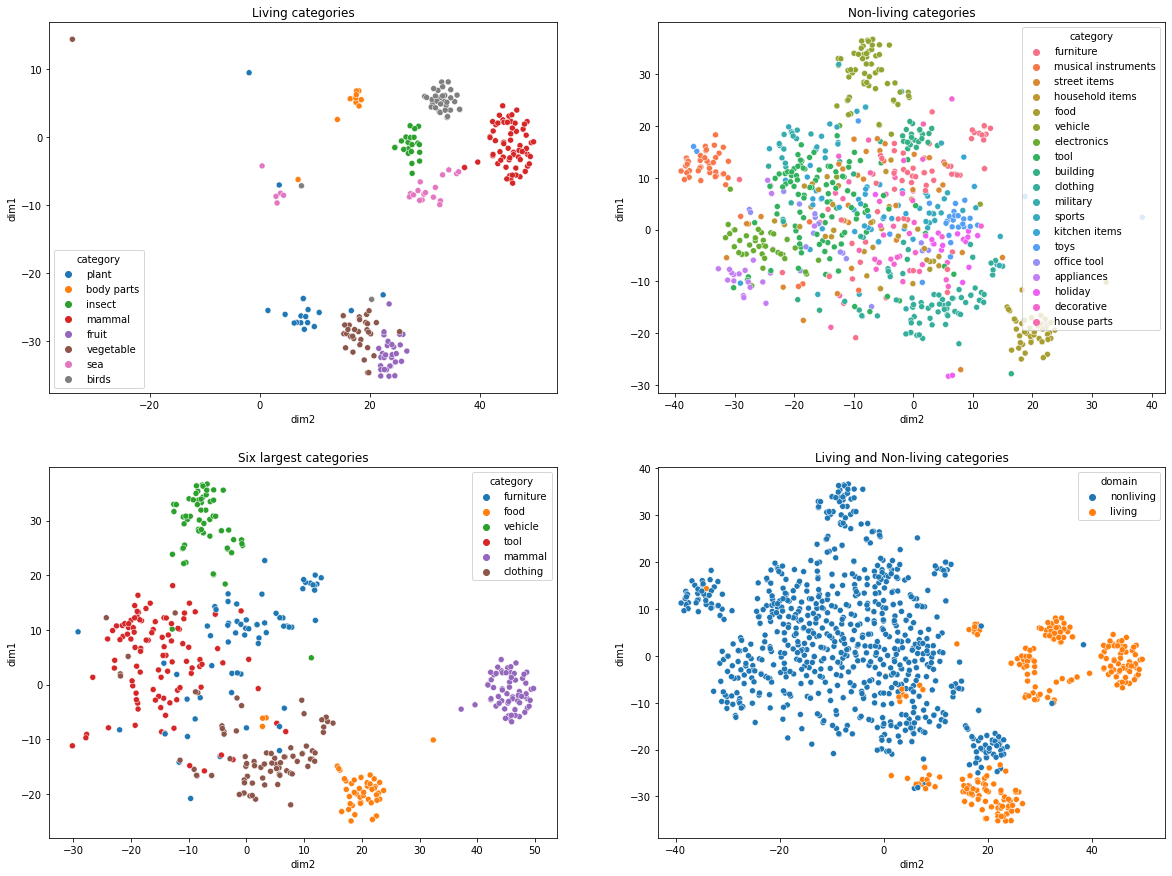

In [55]:
g,Ax=plt.subplots(2,2)

Ax[0,0].set_title('Living categories')
visdat=df_tsnevis[df_tsnevis['domain']=='living']
sns.scatterplot(ax=Ax[0,0],x='dim2', y='dim1', data=visdat, hue='category')

Ax[0,1].set_title('Non-living categories')
visdat=df_tsnevis[df_tsnevis['domain']=='nonliving']
sns.scatterplot(ax=Ax[0,1],x='dim2', y='dim1', data=visdat, hue='category')

Ax[1,0].set_title('Six largest categories')
visdat=df_tsnevis[df_tsnevis['category'].isin(['tool','clothing','furniture','mammal','vehicle','food'])]
sns.scatterplot(ax=Ax[1,0],x='dim2', y='dim1', data=visdat, hue='category')

Ax[1,1].set_title('Living and Non-living categories')
visdat=df_tsnevis
sns.scatterplot(ax=Ax[1,1],x='dim2', y='dim1', data=visdat, hue='domain')

g.set_size_inches(20,15)